In [1]:
import xarray as xr
import numpy as np
import os

In [2]:
def get_data():
    from pathlib import Path
    filelist=[]
    dir_data = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
    for filename in Path(dir_data).rglob('*.nc'):
#    dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/data/'
#    for filename in Path(dir_data).rglob('*.nc'):
        filelist.append(filename)
#    ds=xr.open_mfdataset(filelist,chunks={'time':12,'zlev':1,'lat':720,'lon':720},combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=xr.open_mfdataset(filelist,combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=ds.isel(zlev=0)
    ds = ds.resample(time='M',keep_attrs=True).mean(skipna=False,keep_attrs=True)
    ds = ds.chunk(chunks={'time':12,'lat':720,'lon':720})
    #ds = ds.sel(lat=slice(20,90),lon=slice(-180,-100))
    #print(filelist)
    return ds
def get_data_quarterly():
    from pathlib import Path
    filelist=[]
    dir_data = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
    for filename in Path(dir_data).rglob('*.nc'):
#    dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/data/'
#    for filename in Path(dir_data).rglob('*.nc'):
        filelist.append(filename)
#    ds=xr.open_mfdataset(filelist,chunks={'time':12,'zlev':1,'lat':720,'lon':720},combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=xr.open_mfdataset(filelist,combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=ds.isel(zlev=0)
    ds = ds.resample(time='QS-DEC',keep_attrs=True).mean(skipna=False,keep_attrs=True)
    ds = ds.chunk(chunks={'time':12,'lat':720,'lon':720})
    #ds = ds.sel(lat=slice(20,90),lon=slice(-180,-100))
    #print(filelist)
    return ds

In [5]:
    from pathlib import Path
    filelist=[]
    dir_data = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
    for filename in Path(dir_data).rglob('*.nc'):
#    dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/data/'
#    for filename in Path(dir_data).rglob('*.nc'):
        filelist.append(filename)
#    ds=xr.open_mfdataset(filelist,chunks={'time':12,'zlev':1,'lat':720,'lon':720},combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=xr.open_mfdataset(filelist,combine='nested',concat_dim='time')#.rename({'latitude':'lat','longitude':'lon'})
    ds=ds.isel(zlev=0)


In [12]:
#calculate climatology & anomaly
#calculate frequency timeseries > 90th percentile, remove trends in data
ds_sst=ds.chunk(chunks={'time':24,'lat':720,'lon':720})
ds2=ds_sst.where(ds_sst.sst>-10)  #put all sst values < -10 to nan
annual_mean = ds2.rolling(time=12, center=True).mean()
ds3 = ds2-annual_mean  #take out annual mean to remove trends
climatology_mean = ds3.groupby('time.month').mean('time',keep_attrs=True,skipna=False) #calculate monthly climatology to take out seasonal cycle
anomalies = ds3.groupby('time.month') - climatology_mean  #calculate anomaly timeseries 
perc = anomalies.groupby('time.month').reduce(np.nanpercentile, dim='time', q=0.90)  #caluclate 90th percentile
anomalies_perc = anomalies.groupby('time.month')/perc  #calculate anomaly fraction of 90th percentile
perc_sum_data=anomalies_perc.where(anomalies_perc.sst>=1) #save when data >= 90th percentile
norm = perc_sum_data / perc_sum_data  #this will put 1 where >=1 for summing
psum = norm.groupby('time.year').sum(dim='time')  #sum over each year


#               ds_mean_tem=ds_tem.sel(time=slice(date_start,date_end))
#                data_climatology = ds_mean_tem.groupby('time.month').mean('time',keep_attrs=True,skipna=False)
#                data_anomaly = ds.groupby('time.month') - data_climatology            
 

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


MemoryError: Unable to allocate array with shape (13960, 720, 1440, 12) and data type float32

In [11]:
ds_sst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13960)
Coordinates:
    zlev     float32 0.0
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2019-11-20
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 720), meta=np.ndarray>
    anom     (time, lat, lon) float32 dask.array<chunksize=(12, 720, 720), meta=np.ndarray>
    err      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 720), meta=np.ndarray>
    ice      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 720), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          Daily-OI-V2, final, Data (Ship, Buoy, AVHRR, GSFC-ice)
    History:        Version 2.0
    creation_date:  2011-05-04
    Source:         NOAA/National Climatic Data Center
    Contact:        Dick Reynolds, email: Richard.W.Re

In [ ]:
#marisol movie
import cartopy.crs as ccrs                  
import cartopy.feature as cf                
import matplotlib.pyplot as plt
import cartopy as cart
ds_sst = get_data()
icnt=0
for itime in range(-107,-1):
    ds=ds_sst.isel(time=itime)#.sel(lat=slice(20,90),lon=slice(100,250))
    ds.coords['lon']=(ds.coords['lon']+180)%360-180
    ds=ds.sortby(ds.lon)
    fig = plt.figure(figsize=(8,8))
    #ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-150.0))  # create a set of axes with Mercator projection
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds.lon.values,ds.lat.values,ds.anom,transform=ccrs.PlateCarree(),cmap='jet',vmin=-3,vmax=3);
    #im=ax.pcolormesh(ds.lon.values,ds.lat.values,ds.anom,transform=ccrs.PlateCarree(),cmap='rainbow',vmin=-3,vmax=3);
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k',facecolor='k')
    #ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-110,20,70])
    #ax.set_extent([100,250,20,80])
    #ax.legend()
    cax = fig.add_axes([0.62, 0.68, 0.25, 0.01])#,crs=ccrs.NorthPolarStereo)
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal') #,color='w')
    cbar.ax.tick_params(color="white", width=3, length=7)
    #ticklabs = cbar.ax.get_xticklabels()
    #cbar.ax.set_xticklabels(ticklabs, fontsize=10,color='w')
    cbytick_obj = plt.getp(cbar.ax.axes, 'xticklabels')                #tricky
    plt.setp(cbytick_obj, color='w',weight='bold')
    cbar.set_label('SST ($^\circ$C)',color='w',weight='bold')
    pltdate=ds.time
    text=ax.text(225,21,np.datetime_as_string(pltdate, unit='D'),size=20,transform=ccrs.PlateCarree(),zorder=100)
    adir_figs='F:/data/NASA_biophysical/blob/monthly/'
    fname=adir_figs+'_tmp'+str(icnt).zfill(4)+'.png'
    icnt+=1
    print(fname)
    plt.savefig(fname) 
    plt.clf()


In [132]:
import cartopy.crs as ccrs                  
import cartopy.feature as cf                
import matplotlib.pyplot as plt
import cartopy as cart
ds_sst = get_data_quarterly()
icnt=0
for itime in range(-107,-1):
    ds=ds_sst.isel(time=itime)#.sel(lat=slice(20,90),lon=slice(100,250))
    ds.coords['lon']=(ds.coords['lon']+180)%360-180
    ds=ds.sortby(ds.lon)
    fig = plt.figure(figsize=(8,8))
    #ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-150.0))  # create a set of axes with Mercator projection
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds.lon.values,ds.lat.values,ds.anom,transform=ccrs.PlateCarree(),cmap='jet',vmin=-3,vmax=3);
    #im=ax.pcolormesh(ds.lon.values,ds.lat.values,ds.anom,transform=ccrs.PlateCarree(),cmap='rainbow',vmin=-3,vmax=3);
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k',facecolor='k')
    #ax.coastlines(resolution='10m')                
    ax.set_extent([-180,-110,20,70])
    #ax.set_extent([100,250,20,80])
    #ax.legend()
    cax = fig.add_axes([0.62, 0.68, 0.25, 0.01])#,crs=ccrs.NorthPolarStereo)
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal') #,color='w')
    cbar.ax.tick_params(color="white", width=3, length=7)
    #ticklabs = cbar.ax.get_xticklabels()
    #cbar.ax.set_xticklabels(ticklabs, fontsize=10,color='w')
    cbytick_obj = plt.getp(cbar.ax.axes, 'xticklabels')                #tricky
    plt.setp(cbytick_obj, color='w',weight='bold')
    cbar.set_label('SST ($^\circ$C)',color='w',weight='bold')
    pltdate=ds.time
    text=ax.text(225,21,np.datetime_as_string(pltdate, unit='D'),size=20,transform=ccrs.PlateCarree(),zorder=100)
    adir_figs='F:/data/NASA_biophysical/blob/quarterly/'
    fname=adir_figs+'_tmp'+str(icnt).zfill(4)+'.png'
    icnt+=1
    print(fname)
    plt.savefig(fname) 
    plt.clf()
    
#ds=xr.open_dataset('F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/200001/avhrr-only-v2.20000101.nc')
#ds.close()
#ds
#ds_sst

F:/data/NASA_biophysical/blob/quarterly/_tmp0000.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0001.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0002.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0003.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0004.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0005.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0006.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0007.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0008.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0009.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0010.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0011.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0012.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0013.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0014.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0015.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0016.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0017.png
F:/data/NASA_biophysical/blob/quarterly/_tmp00

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


F:/data/NASA_biophysical/blob/quarterly/_tmp0020.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0021.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0022.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0023.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0024.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0025.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0026.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0027.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0028.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0029.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0030.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0031.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0032.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0033.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0034.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0035.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0036.png
F:/data/NASA_biophysical/blob/quarterly/_tmp0037.png
F:/data/NASA_biophysical/blob/quarterly/_tmp00

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [219]:
#make global image with orthographic projection
from palettable import colorbrewer
#ds_sst = get_data()
icnt=0
for itime in range(-100,0):
    ds=ds_sst.isel(time=itime)#.sel(lat=slice(20,90),lon=slice(100,250))
    ds.coords['lon']=(ds.coords['lon']+180)%360-180
    ds=ds.sortby(ds.lon)
    ds2=ds
    #mask to get ice to be white and land to be blue marble by setting max value and then 
    #setting ice areas to higher than max value
    ds2=ds.where(ds.anom<=3,other=2.99)
    ds2=ds2.where(np.isfinite(ds.anom))
    ds2=ds2.where(np.isnan(ds.ice),other=3.5)
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection = ccrs.Orthographic(-150,30))  # create a set of axes with Mercator projection
    #ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    cmap = colorbrewer.get_map('Spectral', 'diverging', 11, reverse=True).mpl_colormap
    im=ax.pcolormesh(ds.lon.values,ds.lat.values,ds2.anom,transform=ccrs.PlateCarree(),cmap=cmap,vmin=-3,vmax=3);
    cmap.set_over('w',1)
    ax.background_img(name='BM', resolution='high')
  #  ax.background_img(name='natural-earth-1', resolution='large')
    cax = fig.add_axes([0.91, 0.25, 0.02, 0.5])#,crs=ccrs.NorthPolarStereo)
    cbar = fig.colorbar(im,cax=cax, orientation='vertical') #,color='w')
    cbar.set_label('$\Delta$ SST ($^\circ$C)',color='k',weight='bold')
    pltdate=ds.time
    text=plt.figtext(.8,.8,np.datetime_as_string(pltdate, unit='D'),size=20) #,transform=ccrs.PlateCarree(),zorder=100)
    adir_figs='F:/data/NASA_biophysical/blob/monthly_globe/'
    fname=adir_figs+'_tmp'+str(icnt).zfill(4)+'.png'
    icnt+=1
    print(fname)
    plt.savefig(fname) 
    plt.clf()


F:/data/NASA_biophysical/blob/monthly_globe/_tmp0000.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0001.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0002.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0003.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0004.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0005.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0006.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0007.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0008.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0009.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0010.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0011.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0012.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0013.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0014.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0015.png
F:/data/NASA_biophysical/blob/monthly_globe/_tmp0016.png
F:/data/NASA_biophysical/blob/m

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

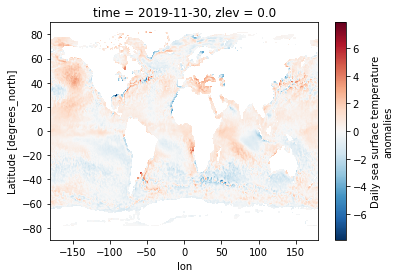

In [183]:
ds2=ds.where(np.isnan(ds.ice))
ds2.anom.plot()

In [ ]:
#adir = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
#filename_sst = adir + '198110/avhrr-only-v2.19811018.nc'  #filename_sst = 'C:/Users/gentemann/Desktop/HadISST_sst.nc' #"F:/data/sst/hadisst/HadISST_sst.nc"
#ds_sst=xr.open_dataset(filename_sst,drop_variables = {'err','sst','ice'})istart_flag = 0 
#make timeseries for 0-40 increments of data
dir_in = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
dir_out = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only_ts/'
for proc_lon in range(0,360,10):
    istart_flag=0
    dataset=[]
    dataset2=[]
    for root, dirs, files in os.walk(dir_in, topdown=False):
        for name in files:
            #syr=int(root[-6:-2])
            #if syr==proc_year:
            if name.startswith("avhrr-only-v2"):
                filename_sst = os.path.join(root, name)
                    #dsx = xr.open_dataset(filename_sst,drop_variables = {'err','sst','ice'})
                dataset2 = xr.open_dataset(filename_sst,drop_variables = {'err','sst','ice'})
                dataset3 = dataset2.sel(lon=slice(proc_lon,proc_lon+10))
                if istart_flag == 0:
                    dataset = dataset3
                    istart_flag = 1
                    continue
                else:
                    dataset = xr.concat([dataset, dataset3],'time')
                    print(dataset3.time[0].data)
    filename_out_nc = dir_out + 'annual/' + str(proc_lon) + 'all_data.nc'
    dataset.to_netcdf(filename_out_nc)
#            istart=istart+1
#            if istart>20:
#                print(istart)
#                iend=1
#                break
#        if iend==1:
#            break
#    if iend==1:
#        break


In [ ]:
dir_in = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
filename_sst = dir_in+'198109/avhrr-only-v2.19810901.nc'
dataset2 = xr.open_dataset(filename_sst,drop_variables = {'err','sst','ice'})
dataset2

In [ ]:
proc_lon=0
dataset3 = dataset2.sel(lon=slice(proc_lon,proc_lon+10))
proc_lon=10
dataset4 = dataset2.sel(lon=slice(proc_lon,proc_lon+10))

In [ ]:
print(dataset3.lon[0].data,dataset3.lon[-1].data)
print(dataset4.lon[0].data,dataset4.lon[-1].data)

In [ ]:
istart_flag=0
dir_base = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/' 
dir_in = dir_base + 'annual/'
dir_in2 = dir_base + 'annual2/'
for root, dirs, files in os.walk(dir_in, topdown=False):
    for name in files:
        filename_sst = os.path.join(root, name)
        print(name)
        dataset2 = xr.open_dataset(filename_sst)
        if istart_flag == 0:
            dataset = dataset2
            istart_flag = 1
            print(dataset2.time[0].data)
            continue
        else:
            dataset = xr.concat([dataset, dataset2],'time')
            print(dataset2.time[0].data)
dataset.to_netcdf(dir_in2 + 'all_data.nc')



In [ ]:
fname = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/annual/1987all_data.nc'
ds=xr.open_dataset(fname)

In [ ]:
ds

In [ ]:
istart_flag = 0 
adir = 'F:/data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/access/avhrr-only/'
for root, dirs, files in os.walk(dir_in, topdown=False):
    for name in files:
        if name.startswith("avhrr"):
            filename_sst=os.path.join(root, name)
            print(root[-6:-2])

F:/data/NASA_biophysical/blob/monthly/_tmp0000.png
F:/data/NASA_biophysical/blob/monthly/_tmp0001.png
F:/data/NASA_biophysical/blob/monthly/_tmp0002.png
F:/data/NASA_biophysical/blob/monthly/_tmp0003.png
F:/data/NASA_biophysical/blob/monthly/_tmp0004.png
F:/data/NASA_biophysical/blob/monthly/_tmp0005.png
F:/data/NASA_biophysical/blob/monthly/_tmp0006.png
F:/data/NASA_biophysical/blob/monthly/_tmp0007.png
F:/data/NASA_biophysical/blob/monthly/_tmp0008.png
F:/data/NASA_biophysical/blob/monthly/_tmp0009.png
F:/data/NASA_biophysical/blob/monthly/_tmp0010.png
F:/data/NASA_biophysical/blob/monthly/_tmp0011.png
F:/data/NASA_biophysical/blob/monthly/_tmp0012.png
F:/data/NASA_biophysical/blob/monthly/_tmp0013.png
F:/data/NASA_biophysical/blob/monthly/_tmp0014.png
F:/data/NASA_biophysical/blob/monthly/_tmp0015.png
F:/data/NASA_biophysical/blob/monthly/_tmp0016.png
F:/data/NASA_biophysical/blob/monthly/_tmp0017.png
F:/data/NASA_biophysical/blob/monthly/_tmp0018.png
F:/data/NASA_biophysical/blob/m

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


F:/data/NASA_biophysical/blob/monthly/_tmp0020.png
F:/data/NASA_biophysical/blob/monthly/_tmp0021.png
F:/data/NASA_biophysical/blob/monthly/_tmp0022.png
F:/data/NASA_biophysical/blob/monthly/_tmp0023.png
F:/data/NASA_biophysical/blob/monthly/_tmp0024.png
F:/data/NASA_biophysical/blob/monthly/_tmp0025.png
F:/data/NASA_biophysical/blob/monthly/_tmp0026.png
F:/data/NASA_biophysical/blob/monthly/_tmp0027.png
F:/data/NASA_biophysical/blob/monthly/_tmp0028.png
F:/data/NASA_biophysical/blob/monthly/_tmp0029.png
F:/data/NASA_biophysical/blob/monthly/_tmp0030.png
F:/data/NASA_biophysical/blob/monthly/_tmp0031.png
F:/data/NASA_biophysical/blob/monthly/_tmp0032.png
F:/data/NASA_biophysical/blob/monthly/_tmp0033.png
F:/data/NASA_biophysical/blob/monthly/_tmp0034.png
F:/data/NASA_biophysical/blob/monthly/_tmp0035.png
F:/data/NASA_biophysical/blob/monthly/_tmp0036.png
F:/data/NASA_biophysical/blob/monthly/_tmp0037.png
F:/data/NASA_biophysical/blob/monthly/_tmp0038.png
F:/data/NASA_biophysical/blob/m

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [125]:
ds_sst.time[-108]

<xarray.DataArray 'time' ()>
array('2010-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-12-31
    zlev     float32 0.0

In [50]:
#calculate frequency timeseries > 90th percentile, remove trends in data
ds2=ds_sst.where(ds_sst.sst>-10)  #put all sst values < -10 to nan
annual_mean = ds2.rolling(time=12, center=True).mean()
ds3 = ds2-annual_mean  #take out annual mean to remove trends
climatology_mean = ds3.groupby('time.month').mean('time')  #calculate monthly climatology to take out seasonal cycle
anomalies = ds3.groupby('time.month') - climatology_mean  #calculate anomaly timeseries 
perc = anomalies.groupby('time.month').reduce(np.nanpercentile, dim='time', q=0.90)  #caluclate 90th percentile
anomalies_perc = anomalies.groupby('time.month')/perc  #calculate anomaly fraction of 90th percentile
perc_sum_data=anomalies_perc.where(anomalies_perc.sst>=1) #save when data >= 90th percentile
norm = perc_sum_data / perc_sum_data  #this will put 1 where >=1 for summing
psum = norm.groupby('time.year').sum(dim='time')  #sum over each year

#calculate frequency timeseries > 90th percentile, do NOT remove trends in data
ds2=ds_sst.where(ds_sst.sst>-10)  #put all sst values < -10 to nan
climatology_mean = ds2.groupby('time.month').mean('time')  #calculate monthly climatology to take out seasonal cycle
anomalies = ds2.groupby('time.month') - climatology_mean  #calculate anomaly timeseries 
perc = anomalies.groupby('time.month').reduce(np.nanpercentile, dim='time', q=0.90)  #caluclate 90th percentile
anomalies_perc = anomalies.groupby('time.month')/perc  #calculate anomaly fraction of 90th percentile
perc_sum_data=anomalies_perc.where(anomalies_perc.sst>=1) #save when data >= 90th percentile
norm = perc_sum_data / perc_sum_data  #this will put 1 where >=1 for summing
psum2 = norm.groupby('time.year').sum(dim='time')  #sum over each year


ValueError: For window size 12, every chunk should be larger than 6, but the smallest chunk size is 3. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [ ]:
psum.sst[:,50,40].plot()
psum2.sst[:,50,40].plot()
#anomalies_perc.sst[:,100,40].plot()
#climatology_std.sst[:,100,40].plot()
#(ds2.sst[:,100,40]-annual_mean.sst[:,100,40]).plot()
#a=anomalies_perc.groupby('time.year').sum()
#a

In [ ]:
#print(anomalies.latitude[40],anomalies.longitude[30])


In [ ]:
#print(norm.sst[1:200,50,40])
#hot = (ds2['sst'] >= climatology['sst']+climatology_std['sst']).groupby('time.month').mean('time')

In [ ]:
print(psum)
#stand_anomalies = xr.apply_ufunc(lambda x, m, s: x, # - (m + s),
#   ....:                         ds2.groupby('time.month'),
#   ....:                         climatology_mean, climatology_std)

In [ ]:
#stand_anomalies.sst[:,40,50].plot()

In [ ]:
perc.sst[:,50,40].plot()

In [ ]:
climatology_mean